# Computer Vision - Cats vs. Dogs

Train a CNN on the cats vs. dogs dataset.  The aim of this project is to artificially minimize the dataset, play pretend and practice to work with small datasets.

Try out and compare different approaches.


- CNN: Baseline model from scratch
- Data Augmentation
- Dropout
- Transfer Learning
  - VGG19
  - InceptionResNetV2
  - MobileNetV2
  - NASNetMobile

In [82]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow.keras import models, layers

### Load data

In [83]:
#make dataset artificially small, practice to work with small datasets. We try to train a model on 10% of the original data
(dataset_train_original, dataset_validate_original), info = tfds.load("cats_vs_dogs", split=["train[:10%]", "train[80%:]"], with_info=True)

info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

### Explore data

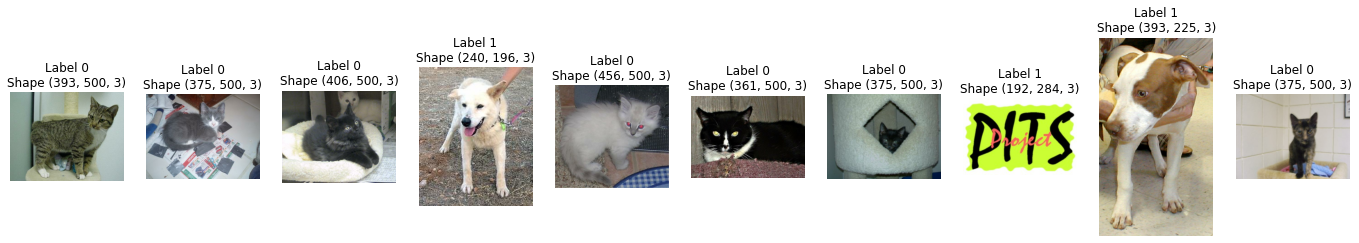

In [84]:
# look at data

index = 1
num_samples = 10
plt.figure(figsize=(24,4))

for sample in dataset_validate_original.shuffle(2500).take(num_samples):
  image = sample['image']
  label = sample['label']
  plt.subplot(1, num_samples, index)
  plt.imshow(image)
  plt.title(f'Label {label}\nShape {image.shape}')
  plt.axis('off')
  #plot subplots, start counting with 1
  index += 1

### Prepare the data for Deep Learning

In [85]:
#normalize image shape: 128x128x3

def encode(sample, image_size=(128,128)):
  '''Normalization: every sample gets split in image, label and resized
  '''
  image = sample["image"]
  #overwrite image with first operation
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  image = tf.image.resize(image, image_size)
  label = sample["label"]
  # 0 and 1 as floats
  label = tf.cast(label, tf.float32)
  return image, label


In [86]:
dataset = dataset_train_original.map(lambda sample: encode(sample))

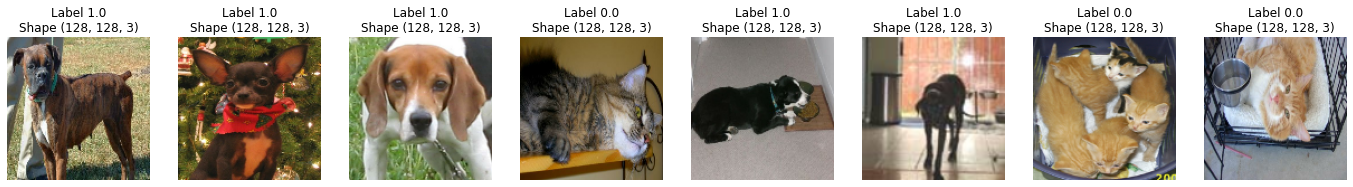

In [87]:
#data is normalized, labels are in float
index = 1
num_samples = 8
plt.figure(figsize=(24,4))
for image, label in dataset.take(num_samples):
  plt.subplot(1, num_samples, index)
  plt.imshow(image)
  plt.title(f"Label {label}\nShape {image.shape}")
  plt.axis("off")
  index += 1

### Create pipeline

In [88]:
dataset_train = dataset_train_original.map(lambda sample: encode(sample)).cache().shuffle(2500).batch(128)

dataset_validate = dataset_validate_original.map(lambda sample:encode(sample)).cache().batch(128)

### Prepare experiments

As we try out different approaches to work with small datasets,w e save the training results in a dictionary.

In [89]:
history_dictionary = {}
epochs = 25

### Experiment 1: Train a CNN from scratch - Baseline model

In [90]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128,128,3)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3),  activation="relu",padding="same"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2,2)))

#flatten and dense layer

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f0582b901d0>>

In [91]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [92]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_validate
)

Epoch 1/25
19/19 [==============================] - 14s 542ms/step - loss: 0.6948 - accuracy: 0.5133 - val_loss: 0.6932 - val_accuracy: 0.4942
Epoch 2/25
19/19 [==============================] - 2s 93ms/step - loss: 0.6788 - accuracy: 0.5821 - val_loss: 0.6982 - val_accuracy: 0.5153
Epoch 3/25
19/19 [==============================] - 2s 87ms/step - loss: 0.6749 - accuracy: 0.5748 - val_loss: 0.6530 - val_accuracy: 0.6447
Epoch 4/25
19/19 [==============================] - 2s 86ms/step - loss: 0.6516 - accuracy: 0.6440 - val_loss: 0.6496 - val_accuracy: 0.6447
Epoch 5/25
19/19 [==============================] - 2s 88ms/step - loss: 0.6367 - accuracy: 0.6354 - val_loss: 0.6608 - val_accuracy: 0.6079
Epoch 6/25
19/19 [==============================] - 2s 87ms/step - loss: 0.5886 - accuracy: 0.6892 - val_loss: 0.6117 - val_accuracy: 0.6730
Epoch 7/25
19/19 [==============================] - 2s 86ms/step - loss: 0.5642 - accuracy: 0.7085 - val_loss: 0.5888 - val_accuracy: 0.6902
Epoch 8/25


In [93]:
history_dictionary["baseline"] = history.history

Explore results

In [94]:
#helper function: plot results and save to experiment history
def render_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

    plt.plot(history["accuracy"], label="accuracy")
    plt.plot(history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Our accuracies")
    plt.show()
    plt.close()


def compare_histories():
    for training_name, history in history_dictionary.items():
        plt.plot(history["val_accuracy"], label=training_name)
    plt.legend()
    plt.title("Comparision of val_accuracy")
    plt.show()
    plt.close()

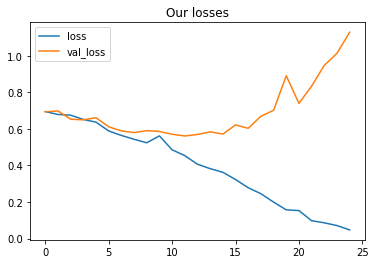

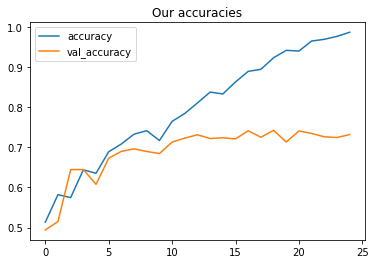

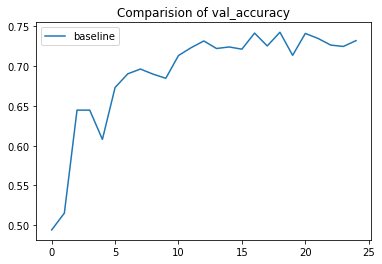

In [95]:
render_history(history.history)
compare_histories()

We have overfitting. We could try to use more data, but that's not possible. Try out different approaches.

Next step: Data Augmentation

### Experiment 2: Data Augmentation

Artificially make more data by flipping image, change color or contrast etc.

In [96]:
#release memory
tf.keras.backend.clear_session()

In [97]:
#get more data by augmentation
#this only happens inside the batch virtually
def augment(image,label):
  image_augmented = image
  image_augmented = tf.image.random_flip_left_right(image_augmented) #2 times the amount of data
  iamge_augmented = tf.image.random_flip_up_down(image_augmented) #4 times the amount of data #50% gets flipped every time
  image_augmented = tf.image.random_contrast(image_augmented, 0.5, 1.0)
  image_augmented = tf.image.random_brightness(image_augmented, 0.25)
  image_augmented = tf.clip_by_value(image_augmented, 0.0, 1.0)
  image_augmented = tf.image.random_hue(image_augmented, 0.2) #moves color in color spectrum
  return image_augmented, label

Examine data

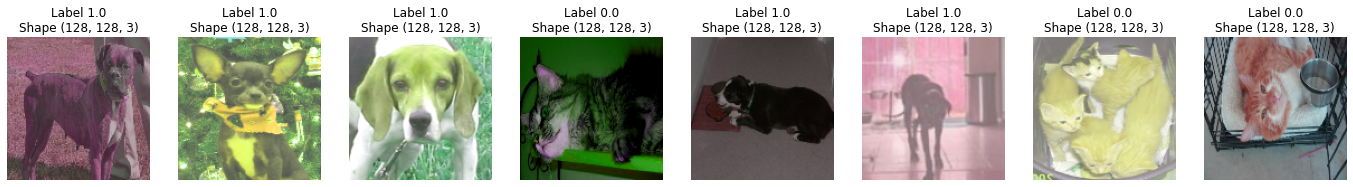

In [98]:
dataset = dataset_train_original.map(lambda sample: encode(sample))
dataset = dataset.map(lambda image, label: augment(image, label))

index = 1
num_samples = 8
plt.figure(figsize=(24,4))
for image, label in dataset.take(num_samples):
  plt.subplot(1, num_samples, index)
  plt.imshow(image)
  plt.title(f"Label {label}\nShape {image.shape}")
  plt.axis("off")
  index += 1

### Create pipeline

In [99]:
#we need to train a new dataset!
#carefull where the cache is. Here we cache differently, after encode, because of augmentation

dataset_train_augmented = dataset_train_original.map(lambda sample: encode(sample)).cache().map(lambda image, label: augment(image, label))
dataset_train_augmented = dataset_train_augmented.shuffle(2500).batch(128)

We train the same CNN but plug in the augmented dataset.

In [100]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3,3), activation="relu", padding="same",input_shape=(128,128,3)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(32, (3,3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3),  activation="relu",padding="same"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3),  activation="relu",padding="same"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()


model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


history = model.fit(
    #take augmented dataset!
    dataset_train_augmented,
    epochs=epochs,
    validation_data=dataset_validate
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [101]:
#save results under new name
history_dictionary["augmented"] = history.history

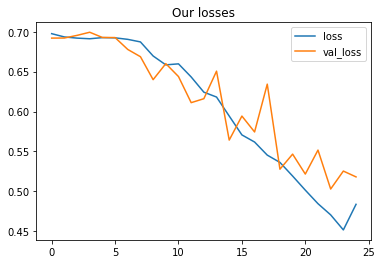

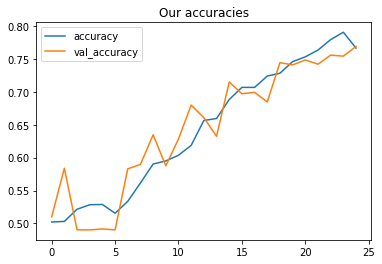

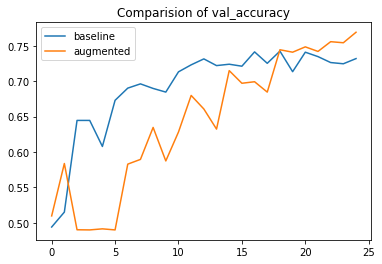

In [102]:
render_history(history.history)
compare_histories()

Results are not really getting better. Augmentation doesn't seem to work on this dataset. Try a different method: Add Dropoout layers to the architecture.

### Experiment 3: Dropout Layers

Regularization technique to prevent overfitting.

In [103]:
tf.keras.backend.clear_session()

In [104]:
#add dropout layers to the architecture

model = models.Sequential()

model.add(layers.Conv2D(32, (3,3), activation="relu", padding="same",input_shape=(128,128,3)))
model.add(layers.Dropout(0.2)) #adds 20% noise to CNN, slowly increase dropout over layers
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(32, (3,3), activation="relu", padding="same"))
model.add(layers.Dropout(0.25))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3),  activation="relu",padding="same"))
model.add(layers.Dropout(0.3))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3),  activation="relu",padding="same"))
model.add(layers.Dropout(0.35))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()


model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_validate
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                    

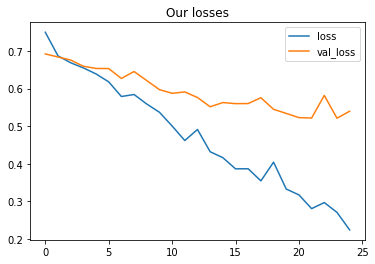

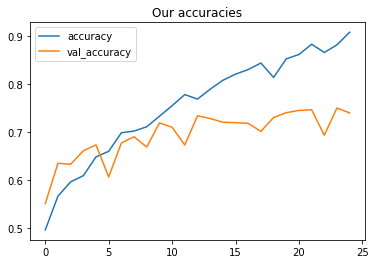

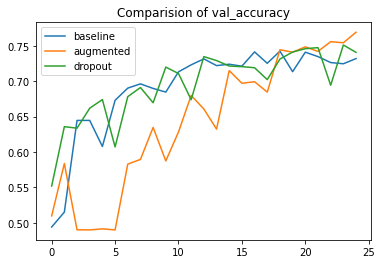

In [105]:
history_dictionary["dropout"] = history.history

render_history(history.history)
compare_histories()

Better than augmented, but not much better than the Baseline model. Now we try Transfer Learning.

### Experiment 4: Transfer Learning

Take someone elses model and finetune it on your dataset.

#### Model VGG19

In [106]:
tf.keras.backend.clear_session()

In [107]:
#get model VGG19 and other models from keras.applications
base_net = tf.keras.applications.VGG19(
    include_top=False, #we don't want to use everything from the model
    input_shape=(128,128,3) #that's the shape we want!
)

base_net.trainable=False #we don't want a couple of million features/parameters

In [108]:
base_net.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [109]:
#what we did is not trainable yet, so we create another model

base_net = tf.keras.applications.VGG19(
    include_top=False,
    input_shape=(128,128,3)
)

base_net.trainable=False 

model = models.Sequential()

#Transfer Learning part
model.add(base_net)

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21,073,217
Trainable params: 1,048,833
Non

In [110]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_validate
)

Epoch 1/25
19/19 [==============================] - 11s 572ms/step - loss: 0.6801 - accuracy: 0.6496 - val_loss: 0.4946 - val_accuracy: 0.7334
Epoch 2/25
19/19 [==============================] - 10s 558ms/step - loss: 0.4737 - accuracy: 0.7700 - val_loss: 0.4107 - val_accuracy: 0.7936
Epoch 3/25
19/19 [==============================] - 10s 565ms/step - loss: 0.4293 - accuracy: 0.8027 - val_loss: 0.3780 - val_accuracy: 0.8409
Epoch 4/25
19/19 [==============================] - 10s 568ms/step - loss: 0.3925 - accuracy: 0.8130 - val_loss: 0.3569 - val_accuracy: 0.8519
Epoch 5/25
19/19 [==============================] - 10s 561ms/step - loss: 0.3636 - accuracy: 0.8388 - val_loss: 0.3352 - val_accuracy: 0.8495
Epoch 6/25
19/19 [==============================] - 10s 566ms/step - loss: 0.3383 - accuracy: 0.8538 - val_loss: 0.3357 - val_accuracy: 0.8465
Epoch 7/25
19/19 [==============================] - 10s 559ms/step - loss: 0.3298 - accuracy: 0.8650 - val_loss: 0.3604 - val_accuracy: 0.8418

In [111]:
history_dictionary["VGG19"] = history.history

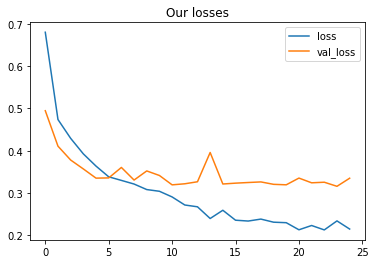

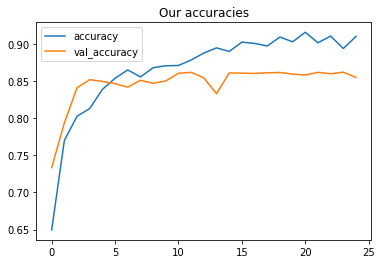

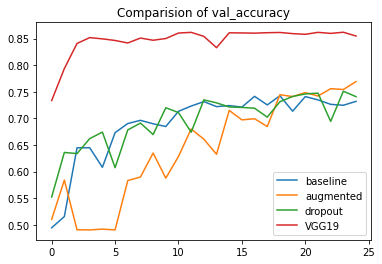

In [112]:
render_history(history.history)
compare_histories()

This is already much better. Try out different pretrained models and compare the results.

#### Model InceptionResNetV2

In [113]:
base_net = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    input_shape=(128,128,3)
)

base_net.trainable=False 

model = models.Sequential()

#Transfer Learning part
model.add(base_net)

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()



model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_validate
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 6144)              0         
                                                                 
 dropout_2 (Dropout)         (None, 6144)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               786560    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                      

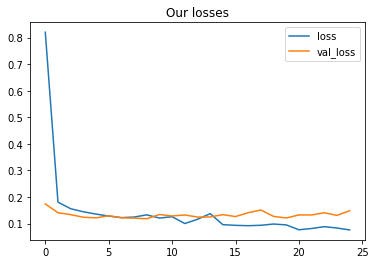

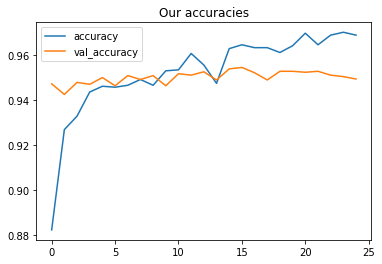

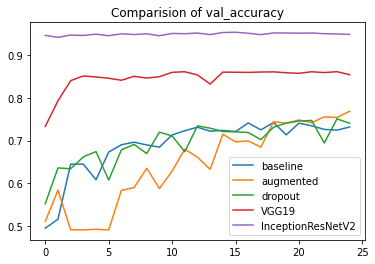

In [114]:
history_dictionary["InceptionResNetV2"] = history.history

render_history(history.history)
compare_histories()

#### Model MobileNetV2

This model takes a different input shape of (224x224x3) so some data preparation is necessary.

In [ ]:
tf.keras.backend.clear_session()

In [115]:
image_size = (224, 224)
dataset_train = dataset_train_original.map(lambda sample: encode(sample, image_size=image_size)).cache().shuffle(2500).batch(128)
dataset_validate = dataset_validate_original.map(lambda sample: encode(sample, image_size=image_size)).cache().batch(128)

In [116]:
base_net = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=image_size + (3,)
)
base_net.trainable = False

In [117]:
model = models.Sequential()

model.add(base_net)

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f05818bc090>>

In [118]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_validate)

Epoch 1/25
19/19 [==============================] - 30s 1s/step - loss: 0.8627 - accuracy: 0.9071 - val_loss: 0.1803 - val_accuracy: 0.9703
Epoch 2/25
19/19 [==============================] - 10s 524ms/step - loss: 0.0977 - accuracy: 0.9725 - val_loss: 0.0581 - val_accuracy: 0.9785
Epoch 3/25
19/19 [==============================] - 9s 512ms/step - loss: 0.0650 - accuracy: 0.9789 - val_loss: 0.0514 - val_accuracy: 0.9832
Epoch 4/25
19/19 [==============================] - 9s 511ms/step - loss: 0.0548 - accuracy: 0.9819 - val_loss: 0.0628 - val_accuracy: 0.9811
Epoch 5/25
19/19 [==============================] - 9s 512ms/step - loss: 0.0319 - accuracy: 0.9884 - val_loss: 0.0757 - val_accuracy: 0.9781
Epoch 6/25
19/19 [==============================] - 9s 513ms/step - loss: 0.0309 - accuracy: 0.9901 - val_loss: 0.0655 - val_accuracy: 0.9811
Epoch 7/25
19/19 [==============================] - 9s 514ms/step - loss: 0.0216 - accuracy: 0.9936 - val_loss: 0.0660 - val_accuracy: 0.9813
Epoch 8

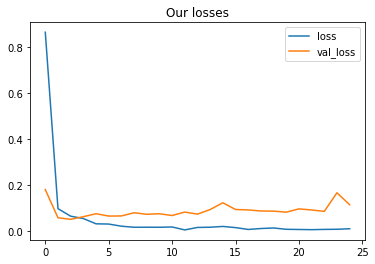

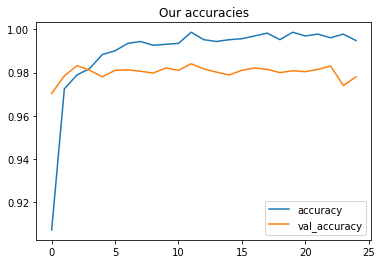

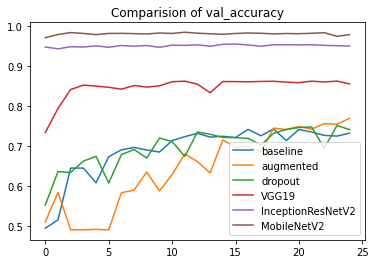

In [119]:
history_dictionary["MobileNetV2"] = history.history

render_history(history.history)
compare_histories()

#### Model NASNetMobile

In [ ]:
tf.keras.backend.clear_session()

In [120]:
#get input shape of (224x224x3)

image_size = (224, 224)
dataset_train = dataset_train_original.map(lambda sample: encode(sample, image_size=image_size)).cache().shuffle(2500).batch(128)
dataset_validate = dataset_validate_original.map(lambda sample: encode(sample, image_size=image_size)).cache().batch(128)

In [121]:
base_net = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=image_size + (3,)
)
base_net.trainable = False

In [122]:
model = models.Sequential()

model.add(base_net)

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

#compile and train 
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_validate
)

history_dictionary["NASNetMobile"] = history.history


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_3 (Flatten)         (None, 62720)             0         
                                                                 
 dropout_6 (Dropout)         (None, 62720)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               8028288   
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                      

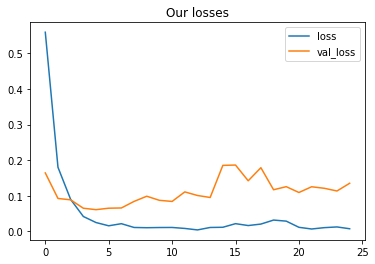

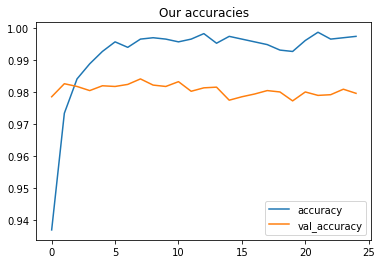

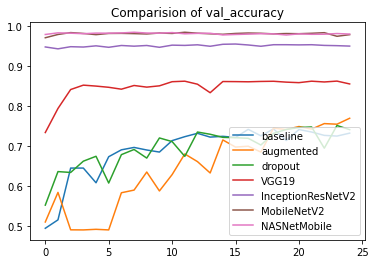

In [123]:
render_history(history.history)
compare_histories()

Transfer Learning is extremly effective and can be used to get good results on small datasets!